In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15,9
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
# import geopandas as gp
import pandas as pd
from shapely.geometry import Point
from shapely import wkt
from shapely.geometry import Polygon

In [6]:
!pip install pandas

In [ ]:
!conda install pandas

Solving environment: done

## Package Plan ##

  environment location: /Users/neerajpadarthi/anaconda3

  added / updated specs:
    - pandas


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    mkl_fft-1.0.10             |   py37h5e564d8_0         153 KB
    mkl_random-1.0.2           |   py37h27c97d8_0         358 KB
    pandas-0.24.1              |   py37h0a44026_0         9.9 MB
    pip-19.0.1                 |           py37_0         1.8 MB
    python-3.7.2               |       haf84260_0        21.6 MB
    python-dateutil-2.7.5      |           py37_0         275 KB
    pytz-2018.9                |           py37_0         268 KB
    setuptools-40.8.0          |           py37_0         643 KB
    six-1.12.0                 |           py37_0          22 KB
    wheel-0.32.3               |           py37_0          34 KB
    ----------------------------------------------------------

In [8]:
df = pd.read_csv('sensity_events.csv')

In [13]:
def CustomParser(data):
    import json
    j1 = json.loads(data)
    return j1

In [14]:
df = pd.read_csv('sensity_events.csv', converters={'geometry':CustomParser},header=0)

In [15]:
df.dropna(axis=0,how='any',inplace=True)

In [16]:
df.rename(columns={'start_time':'start_date','end_time':'end_date'},inplace=True)

In [ ]:
df['start_date'] = pd.to_datetime(df.start_date,format='%Y/%m/%d').astype('datetime64[s]')
df['end_date'] = pd.to_datetime(df.end_date,format='%Y/%m/%d').astype('datetime64[s]')

In [18]:
df['temp'] = df.geometry.apply(lambda x: list(x.values())[1][0])

In [19]:
df['poly_latitide']=df.temp.apply(lambda x: list([x[0][0],x[1][0],x[2][0],x[3][0],x[4][0]]))
df['poly_longitude']=df.temp.apply(lambda x: list([x[0][1],x[1][1],x[2][1],x[3][1],x[4][1]]))

In [20]:
df['mc']=(df.apply(lambda x: (list(zip(x[9], x[10]))), axis=1))

In [21]:
df['mc']=df['mc'].apply(Polygon)

In [22]:
df.drop(columns='latitude',inplace=True)
df.drop(columns='longitude',inplace=True)
df.drop(columns='geometry',inplace=True)
df.drop(columns='session_type',inplace=True)
df.drop(columns='temp',inplace=True)
df.drop(columns='uuid',inplace=True)

In [24]:
gdf = gp.GeoDataFrame(df, geometry='mc')

In [26]:
gdf.drop(columns='poly_latitide',inplace=True)
gdf.drop(columns='poly_longitude',inplace=True)

In [27]:
gdf.head()

,asset_id,start_date,end_date,mc
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,POLYGON ((-94.58345988501729 39.10980192221204...
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,POLYGON ((-94.58075470021177 39.10952049535309...
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,"POLYGON ((-94.5834062421616 39.09438467559006,..."
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,POLYGON ((-94.58352497138776 39.09532433668034...
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,POLYGON ((-94.58362870013082 39.09300515414148...


In [30]:
dist_df = df[['asset_id','start_date','end_date','mc']].astype(str).drop_duplicates()

In [34]:
dist_df.dtypes

asset_id              object
start_date    datetime64[ns]
end_date      datetime64[ns]
mc                    object
dtype: object

In [33]:
dist_df['start_date'] = pd.to_datetime(dist_df.start_date,format='%Y/%m/%d').astype('datetime64[s]')
dist_df['end_date'] = pd.to_datetime(dist_df.end_date,format='%Y/%m/%d').astype('datetime64[s]')

In [36]:
dist_df.isnull().sum()

asset_id      0
start_date    0
end_date      0
mc            0
dtype: int64

In [37]:
dist_df['start_from_fc']= dist_df.start_date.dt.floor('5min')
dist_df['end_from_fc'] = dist_df.end_date.dt.ceil('5min')

In [38]:
dist_df.dtypes

asset_id                 object
start_date       datetime64[ns]
end_date         datetime64[ns]
mc                       object
start_from_fc    datetime64[ns]
end_from_fc      datetime64[ns]
dtype: object

In [39]:
n = (dist_df.end_from_fc - dist_df.start_from_fc)
# n,(n.dt.total_seconds())/60
dist_df['diff'] = (n.dt.total_seconds())/60

In [40]:
dist_df.head(50)

,asset_id,start_date,end_date,mc,start_from_fc,end_from_fc,diff
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,POLYGON ((-94.58345988501729 39.10980192221204...,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,POLYGON ((-94.58075470021177 39.10952049535309...,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,"POLYGON ((-94.5834062421616 39.09438467559006,...",2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,POLYGON ((-94.58352497138776 39.09532433668034...,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,POLYGON ((-94.58362870013082 39.09300515414148...,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0
5,SENSITY-kc-14,2018-08-10 23:34:12,2018-08-10 23:39:38,POLYGON ((-94.58338927355908 39.09750784648474...,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0
6,SENSITY-kc-18,2018-08-10 23:36:28,2018-08-10 23:40:19,POLYGON ((-94.58362651400515 39.10811059504851...,2018-08-10 23:35:00,2018-08-10 23:45:00,10.0
7,SENSITY-kc-2,2018-08-10 23:33:24,2018-08-10 23:47:47,POLYGON ((-94.58363955172752 39.08954934986762...,2018-08-10 23:30:00,2018-08-10 23:50:00,20.0
8,SENSITY-kc-12,2018-08-10 23:47:25,2018-08-10 23:47:50,POLYGON ((-94.58350569980166 39.09557414888256...,2018-08-10 23:45:00,2018-08-10 23:50:00,5.0
9,SENSITY-kc-21,2018-08-10 23:47:51,2018-08-10 23:49:26,POLYGON ((-94.58052485305974 39.10914986668804...,2018-08-10 23:45:00,2018-08-10 23:50:00,5.0


In [41]:
dist_df['slots'] = dist_df['diff']/5
dist_df['slots']=dist_df['slots'].astype('int64')
dist_df['bins'] = dist_df.slots.map( lambda x: np.arange(1,x+1,1) if x > 1.0 else np.arange(1,x+1))

In [42]:
dist_df.head()

,asset_id,start_date,end_date,mc,start_from_fc,end_from_fc,diff,slots,bins
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,POLYGON ((-94.58345988501729 39.10980192221204...,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0,1,[1]
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,POLYGON ((-94.58075470021177 39.10952049535309...,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
2,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,"POLYGON ((-94.5834062421616 39.09438467559006,...",2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
3,SENSITY-kc-12,2018-08-10 23:34:44,2018-08-10 23:38:53,POLYGON ((-94.58352497138776 39.09532433668034...,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,"[1, 2]"
4,SENSITY-kc-9,2018-08-10 23:37:38,2018-08-10 23:39:01,POLYGON ((-94.58362870013082 39.09300515414148...,2018-08-10 23:35:00,2018-08-10 23:40:00,5.0,1,[1]


In [43]:
dist_df['start'] = dist_df.start_date.dt.date
dist_df['start'] = pd.to_datetime(dist_df.start,format='%Y\%m\%d')

In [44]:
def explode(df, lst_cols, fill_value=''):
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    if (lens > 0).all():
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [45]:
new_df=explode(dist_df, ['bins'], fill_value='')

In [46]:
new_df.isnull().sum()

asset_id         0
start_date       0
end_date         0
mc               0
start_from_fc    0
end_from_fc      0
diff             0
slots            0
bins             0
start            0
dtype: int64

In [47]:
new_df[new_df['slots'].isnull()]

,asset_id,start_date,end_date,mc,start_from_fc,end_from_fc,diff,slots,bins,start


In [48]:
new_df['bins'] = (new_df.start_from_fc + pd.to_timedelta(5*(new_df['bins']), unit='m'))
new_df['bins1'] = new_df.bins - pd.to_timedelta(5, unit='m')

In [49]:
new_df.head()

,asset_id,start_date,end_date,mc,start_from_fc,end_from_fc,diff,slots,bins,start,bins1
0,SENSITY-kc-23,2018-08-10 23:33:26,2018-08-10 23:33:55,POLYGON ((-94.58345988501729 39.10980192221204...,2018-08-10 23:30:00,2018-08-10 23:35:00,5.0,1,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
1,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,POLYGON ((-94.58075470021177 39.10952049535309...,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
2,SENSITY-kc-22,2018-08-10 23:34:58,2018-08-10 23:36:08,POLYGON ((-94.58075470021177 39.10952049535309...,2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00
3,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,"POLYGON ((-94.5834062421616 39.09438467559006,...",2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:35:00,2018-08-10,2018-08-10 23:30:00
4,SENSITY-kc-10,2018-08-10 23:33:40,2018-08-10 23:36:25,"POLYGON ((-94.5834062421616 39.09438467559006,...",2018-08-10 23:30:00,2018-08-10 23:40:00,10.0,2,2018-08-10 23:40:00,2018-08-10,2018-08-10 23:35:00


In [65]:
new_df.loc[(new_df['asset_id']=='SENSITY-kc-23') & (new_df['bins1']=='2018-11-03 21:45:00')\
          & (new_df.mc.str.contains('94.58387299795793'))]

,asset_id,start_date,end_date,mc,start_from_fc,end_from_fc,diff,slots,bins,start,bins1
1691080,SENSITY-kc-23,2018-11-03 21:44:09,2018-11-03 21:46:02,POLYGON ((-94.58387299795793 39.10971071878577...,2018-11-03 21:40:00,2018-11-03 21:50:00,10.0,2,2018-11-03 21:50:00,2018-11-03,2018-11-03 21:45:00
1691082,SENSITY-kc-23,2018-11-03 21:45:27,2018-11-03 21:47:02,POLYGON ((-94.58387299795793 39.10971071878577...,2018-11-03 21:45:00,2018-11-03 21:50:00,5.0,1,2018-11-03 21:50:00,2018-11-03,2018-11-03 21:45:00


In [70]:
new_df.loc[(new_df['asset_id']=='SENSITY-kc-15') & (new_df.bins1.isin(['2018-09-26 03:20:00','2018-09-26 03:25:00','2018-09-26 03:30:00']))\
          & (new_df.mc.str.contains('94.58354627591267'))].sort_values(by=['bins1'],ascending=True)

,asset_id,start_date,end_date,mc,start_from_fc,end_from_fc,diff,slots,bins,start,bins1
858195,SENSITY-kc-15,2018-09-26 03:24:15,2018-09-26 03:32:53,POLYGON ((-94.58354627591267 39.10087297922868...,2018-09-26 03:20:00,2018-09-26 03:35:00,15.0,3,2018-09-26 03:25:00,2018-09-26,2018-09-26 03:20:00
944742,SENSITY-kc-15,2018-09-26 03:23:16,2018-09-26 03:32:53,POLYGON ((-94.58354627591267 39.10087297922868...,2018-09-26 03:20:00,2018-09-26 03:35:00,15.0,3,2018-09-26 03:25:00,2018-09-26,2018-09-26 03:20:00
858196,SENSITY-kc-15,2018-09-26 03:24:15,2018-09-26 03:32:53,POLYGON ((-94.58354627591267 39.10087297922868...,2018-09-26 03:20:00,2018-09-26 03:35:00,15.0,3,2018-09-26 03:30:00,2018-09-26,2018-09-26 03:25:00
944743,SENSITY-kc-15,2018-09-26 03:23:16,2018-09-26 03:32:53,POLYGON ((-94.58354627591267 39.10087297922868...,2018-09-26 03:20:00,2018-09-26 03:35:00,15.0,3,2018-09-26 03:30:00,2018-09-26,2018-09-26 03:25:00
858197,SENSITY-kc-15,2018-09-26 03:24:15,2018-09-26 03:32:53,POLYGON ((-94.58354627591267 39.10087297922868...,2018-09-26 03:20:00,2018-09-26 03:35:00,15.0,3,2018-09-26 03:35:00,2018-09-26,2018-09-26 03:30:00
944744,SENSITY-kc-15,2018-09-26 03:23:16,2018-09-26 03:32:53,POLYGON ((-94.58354627591267 39.10087297922868...,2018-09-26 03:20:00,2018-09-26 03:35:00,15.0,3,2018-09-26 03:35:00,2018-09-26,2018-09-26 03:30:00


In [51]:
 new_df.groupby(['bins1','bins','asset_id','mc']).count()[['start_from_fc']]

start_from_fc
bins1               bins                asset_id      mc                                                               
2018-08-10 23:30:00 2018-08-10 23:35:00 SENSITY-kc-10 POLYGON ((-94.5834062421616 39.09438467559006, ...              1
                                                      POLYGON ((-94.58340723278391 39.09433099824032,...              1
                                                      POLYGON ((-94.5834087918651 39.0942812171699, -...              1
                                        SENSITY-kc-12 POLYGON ((-94.58351305730527 39.09515061295252,...              1
                                                      POLYGON ((-94.58351797524573 39.09525871438412,...              1
                                                      POLYGON ((-94.58352497138776 39.09532433668034,...              1
                                                      POLYGON ((-94.58352696042861 39.09510952636229,...              1
                                                      POLYGON ((-94.58352923673947 39.09505878874963,...              1
                                        SENSITY-kc-14 POLYGON ((-94.58338194847128 39.09756634200421,...              1
                                                      POLYGON ((-94.58338265049157 39.09761988015187,...              1
                                                      POLYGON ((-94.58338927355908 39.09750784648474,...              1
                                                      POLYGON ((-94.58339447815536 39.09745342112773,...              1
                                        SENSITY-kc-18 POLYGON ((-94.58372803011567 39.10811114627977,...              1
                                                      POLYGON ((-94.5837292056665 39.10811129314391, ...              1
                                                      POLYGON ((-94.58380697893506 39.10809359704761,...              1
                                                      POLYGON ((-94.58380735623905 39.10809344800582,...              1
                                        SENSITY-kc-2  POLYGON ((-94.58363390548824 39.08961012225613,...              1
                                                      POLYGON ((-94.58363456912598 39.08965895698692,...              1
                                                      POLYGON ((-94.58363955172752 39.08954934986762,...              1
                                        SENSITY-kc-22 POLYGON ((-94.58075470021177 39.10952049535309,...              1
                                                      POLYGON ((-94.58077124367973 39.10956874989834,...              1
                                        SENSITY-kc-23 POLYGON ((-94.58306831086506 39.10988287538601,...              1
                                                      POLYGON ((-94.58345988501729 39.10980192221204,...              1
                                                      POLYGON ((-94.58352863934589 39.1097857191241, ...              1
                                                      POLYGON ((-94.58360152584436 39.10976869622928,...              1
                                                      POLYGON ((-94.58367349619498 39.10975377849966,...              1
                                                      POLYGON ((-94.58374716121349 39.10973652671624,...              1
                                                      POLYGON ((-94.58381467774628 39.10972174952396,...              1
                                                      POLYGON ((-94.58388230597346 39.10971102906748,...              1
                                        SENSITY-kc-8  POLYGON ((-94.58349362256754 39.09256383651428,...              1
...                                                                                                                 ...
2018-11-26 15:35:00 2018-11-26 15:40:00 SENSITY-kc-6  POLYGON ((-94.58354635197894 39.09120973830031,...              1
                          

In [60]:
temp_df= new_df.groupby(['bins1','bins','asset_id','mc']).count()[['start_from_fc']]

In [62]:
temp_df.loc[temp_df['start_from_fc']>1]

,,,,start_from_fc
bins1,bins,asset_id,mc,
2018-09-26 03:20:00,2018-09-26 03:25:00,SENSITY-kc-15,"POLYGON ((-94.58354627591267 39.10087297922868, -94.58349526247116 39.10087039016767, -94.5834940662719 39.10088469987251, -94.5835450797134 39.10088728893351, -94.58354627591267 39.10087297922868))",2
2018-09-26 03:25:00,2018-09-26 03:30:00,SENSITY-kc-15,"POLYGON ((-94.58354627591267 39.10087297922868, -94.58349526247116 39.10087039016767, -94.5834940662719 39.10088469987251, -94.5835450797134 39.10088728893351, -94.58354627591267 39.10087297922868))",2
2018-09-26 03:30:00,2018-09-26 03:35:00,SENSITY-kc-15,"POLYGON ((-94.58354627591267 39.10087297922868, -94.58349526247116 39.10087039016767, -94.5834940662719 39.10088469987251, -94.5835450797134 39.10088728893351, -94.58354627591267 39.10087297922868))",2
2018-11-03 21:45:00,2018-11-03 21:50:00,SENSITY-kc-23,"POLYGON ((-94.58387299795793 39.10971071878577, -94.58392988907639 39.10969893124197, -94.58392444231387 39.10968297489328, -94.58386755119541 39.10969476243709, -94.58387299795793 39.10971071878577))",2


In [52]:
df_5min = new_df.groupby(['bins1','bins','asset_id','mc']).count()[['start_from_fc']].add_suffix('_Count').reset_index()

In [53]:
df_5min.rename(columns={'bins1':'start_time','bins':'end_time','asset_id':'sensor_id'
                        ,'start_from_fc_Count':'no_of_cars'}
               ,inplace=True)

In [54]:
df_5min.head()

,start_time,end_time,sensor_id,mc,no_of_cars
0,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-10,"POLYGON ((-94.5834062421616 39.09438467559006,...",1
1,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-10,POLYGON ((-94.58340723278391 39.09433099824032...,1
2,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-10,"POLYGON ((-94.5834087918651 39.0942812171699, ...",1
3,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-12,POLYGON ((-94.58351305730527 39.09515061295252...,1
4,2018-08-10 23:30:00,2018-08-10 23:35:00,SENSITY-kc-12,POLYGON ((-94.58351797524573 39.09525871438412...,1


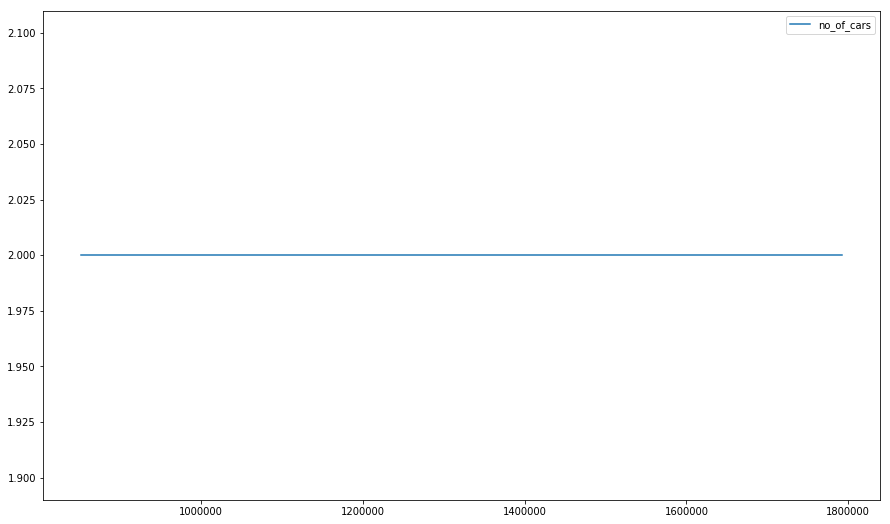

In [80]:
df_5min.loc[df_5min['no_of_cars']>1][['mc','no_of_cars']]

In [129]:
df_del = df_5min.loc[(df_5min['no_of_cars']>1) & (df_5min.mc.str.contains('94.58387299795793'))]
df_del

,start_time,end_time,sensor_id,mc,no_of_cars
1792241,2018-11-03 21:45:00,2018-11-03 21:50:00,SENSITY-kc-23,POLYGON ((-94.58387299795793 39.10971071878577...,2


In [137]:
gdf_del = gp.GeoDataFrame(df_del,geometry='mc' )

TypeError: Input geometry column must contain valid geometry objects.

In [133]:
import folium
m = folium.Map([50.854457, 4.377184], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(gdf_del).add_to(m)
folium.LatLngPopup().add_to(m)
m

KeyError: 'geometry'